In [22]:
import torch as torch
from network.metric.accuracy import acc_srcnn_tiny_radar
from network.models.classifiers.tiny_radar import TinyRadarNN
from network.models.sr_classifier.SRCnnTinyRadar import CombinedSRCNNClassifier
from network.models.super_resolution.drln import Drln
from network.models.super_resolution.srcnn import SRCnn
from network.runner import Runner
from utils.utils_paths import get_time_in_string
from utils.utils_images import Normalization
import os
import cv2
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifftshift, ifft
from functools import partial
from multiprocessing import Pool
from data_loader.tiny_loader import *
from data_loader.tiny_radar_loader import tiny_radar_for_classifier, tiny_tt
from data_loader.tiny_radar_loader import tiny_data_high_res




In [37]:




def evaluation(low_res,high_res_true,high_res_pred):
    print(f"Low res pixel range: {low_res.min()} - {low_res.max()}")
    print(f"High res true pixel range: {high_res_true.min()} - {high_res_true.max()}")
    print(f"High res pred pixel range: {high_res_pred.min()} - {high_res_pred.max()}")
    low_res_up = cv2.resize(low_res, (high_res_true.shape[1], high_res_true.shape[0]), interpolation=cv2.INTER_CUBIC)
    print(f'MSE true vs pred: {np.linalg.norm(high_res_true - high_res_pred)}')
    print(f'MSE true vs up: {np.linalg.norm(high_res_true - low_res_up)}')
    plt.figure(figsize=(20, 20))
    plt.imshow(low_res_up)
    plt.title("Low res")
    plt.show()
    plt.figure(figsize=(20, 20))
    plt.imshow(high_res_true)
    plt.title("High res true")
    plt.show()
    plt.figure(figsize=(20, 20))
    plt.imshow(high_res_pred)
    plt.title("High res pred")
    plt.show()
    plt.figure(figsize=(20, 20))
    plt.imshow(low_res_up)
    plt.title("Low res up sample - cubic")
    plt.show()

In [80]:
numberOfInstanceWindows = 3
lengthOfSubWindow = 32

gestures = [
        "PinchIndex",
        "PinchPinky",
        # "FingerSlider",
        # "FingerRub",
        # "SlowSwipeRL",
        # "FastSwipeRL",
        # "Push",
        # "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/data_feat/"
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"
output_dir = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs"

people = 4
m = Drln(2)
path="/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs/models/sr/Drln_2/11G_normalization.range_0_1/lr_0.0005_batch_size_128_loss_L1/2023-12-27_13:39:19min_loss_model.pt"
m.load_state_dict(torch.load(path,map_location=torch.device('cpu')))


data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"

data = tiny_data_high_res(data_dir, people, gestures,8,Normalization.Range_0_1)
for x,y in data[0]:
    print(x.shape)
    print(y.shape)
    break


People: 4, Gestures: ['PinchIndex', 'PinchPinky'], Batch Size: 8
loading data with 8 cpu cores
concatenating data
torch.Size([8, 1, 8, 123])
torch.Size([8, 1, 32, 492])


In [95]:
res = m(x)
k=4
# evaluation(x[0],y[0],res[0])

Text(0.5, 1.0, 'low res')

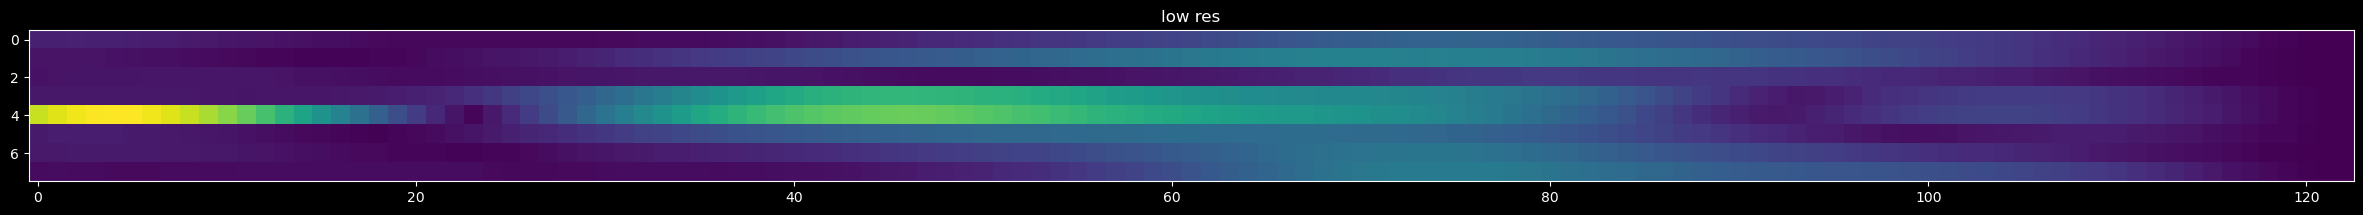

In [96]:
plt.figure(figsize=(30,30))
plt.imshow(x[k,0])
plt.title("low res")

Text(0.5, 1.0, 'high res true')

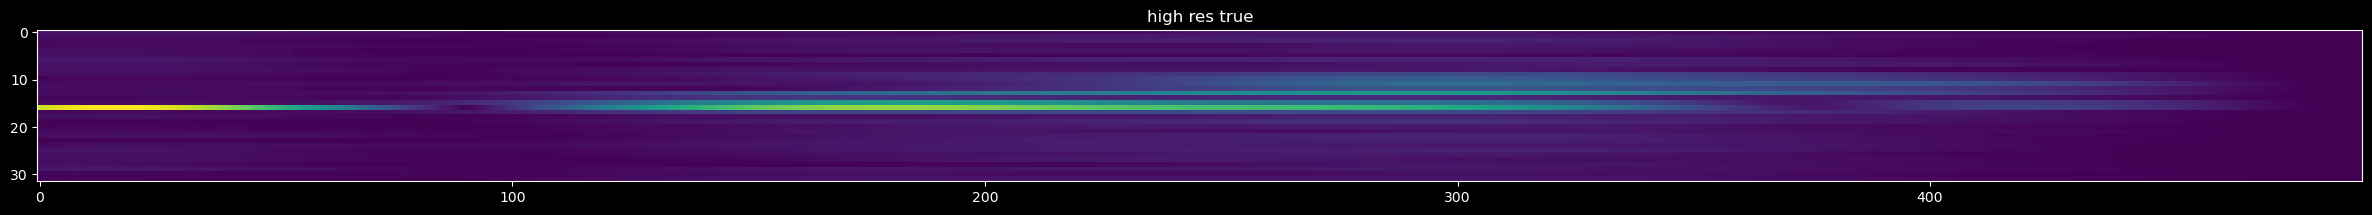

In [97]:
plt.figure(figsize=(30,30))
plt.imshow(y[k,0])
plt.title("high res true")


Text(0.5, 1.0, 'high res pred')

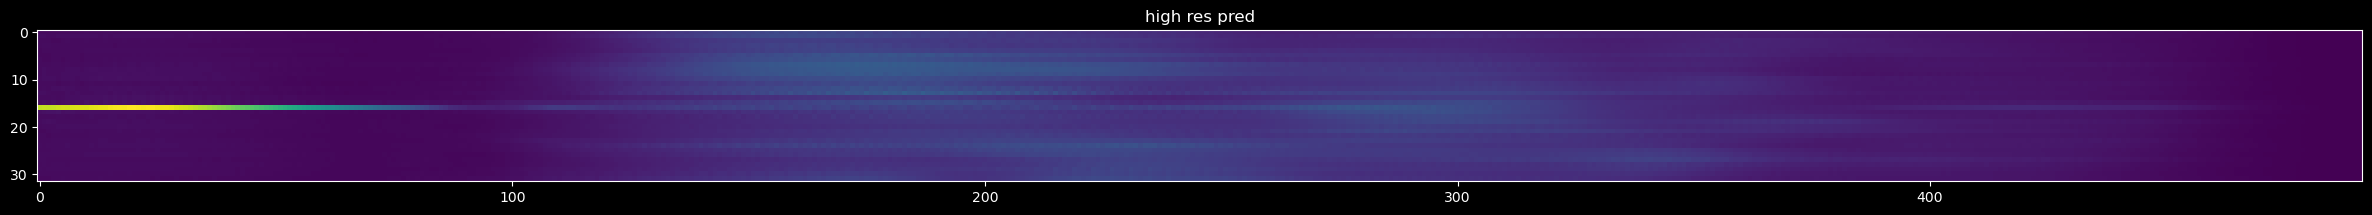

In [98]:
plt.figure(figsize=(30,30))
plt.imshow(res[k,0].detach().numpy())
plt.title("high res pred")


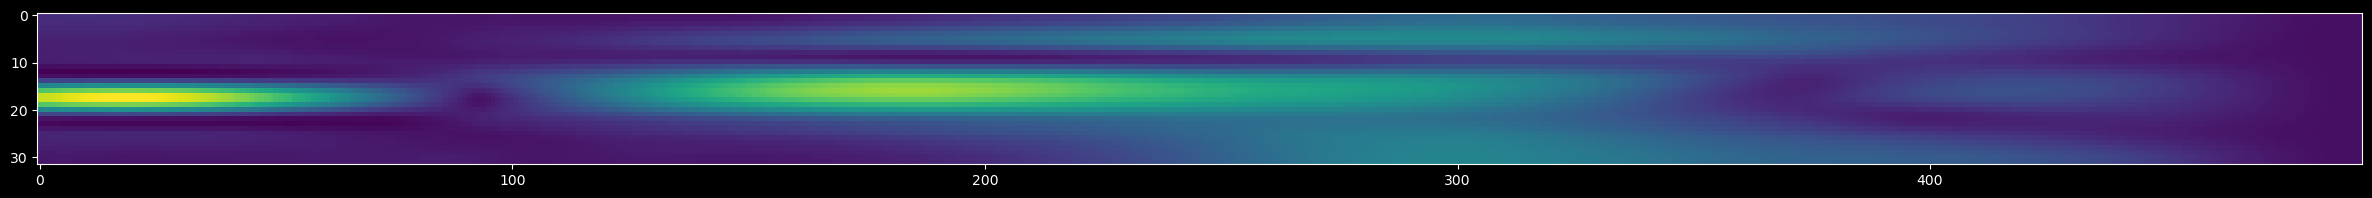

In [99]:
low_up = cv2.resize(x[k,0].detach().numpy(), (492,32), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(30,30))
plt.imshow(low_up)
